# POP MOC(sigma 2) for 0.1-degree
**Input Data:** Monthly POP output timeseries files  
**Output Data:** Monthly mean AMOC sigma 2 timeseries  
**Description:** Computes MOC(sigma 2) offline from POP history files using simple xhistogram binning.  
**Date:** February 2023  
**Creator:** Steve Yeager (https://github.com/sgyeager/POP_MOC/blob/main/notebooks/pop_MOCsigma2_0.1deg.ipynb)  
**Updated:** Fred Castruccio and Teagan King, February 2023  
**Note:** To use the MOCutils, a user will need to clone the POP_MOC repository (https://github.com/sgyeager/POP_MOC) and install MOCutils by going to the POP_MOC directory and running `pip install -e . --user`.

In [2]:
%load_ext autoreload
%autoreload 2
import cftime
import copy
import dask
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from MOCutils import popmoc
import numpy as np  
import os
import pop_tools
import time
import xarray as xr 
from xhistogram.xarray import histogram

In [3]:
from dask.distributed import wait
dask.__version__

'2022.7.0'

In [4]:
# Close out Dask Cluster and release workers:
# cluster.close()
# client.close()

In [5]:
# TODO: optimize dask resources

def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        account='P93300313',
        walltime='06:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(72) 

/glade/u/home/tking/.conda/envs/ipogs/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43322 instead
  warnings.warn(


In [6]:
cluster

AttributeError: 'Tab' object has no attribute '_ipython_display_'

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/43322/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:43407,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/43322/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
def time_set_midmonth(ds, time_name, deep=False):
    """
    Return copy of ds with values of ds[time_name] replaced with mid-month
    values (day=15) rather than end-month values.
    """
    year = ds[time_name].dt.year
    month = ds[time_name].dt.month
    year = xr.where(month==1,year-1,year)
    month = xr.where(month==1,12,month-1)
    nmonths = len(month)
    newtime = [cftime.DatetimeNoLeap(year[i], month[i], 15) for i in range(nmonths)]
    ds[time_name] = newtime
    return ds

# Get the required variables 

In [8]:
#fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002/ocn/proc/tseries/month_1/'
#fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003/ocn/proc/tseries/month_1/'
#fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP45/HR/b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003/ocn/proc/tseries/month_1/'
fdir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP26/HR/b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003/ocn/proc/tseries/month_1/'

#fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002.pop.h.VVEL.200601-210012.nc'
#fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003.pop.h.VVEL.200601-210012.nc'
#fin = fdir + 'b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.VVEL.200601-210012.nc'
fin = fdir + 'b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.VVEL.200601-210012.nc'
dsV = xr.open_dataset(fin, chunks={'time':1,'nlon':100})
dsV = time_set_midmonth(dsV,'time')

#fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002.pop.h.WVEL.200601-210012.nc'
#fin = fdir + 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003.pop.h.WVEL.200601-210012.nc'
#fin = fdir + 'b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.WVEL.200601-210012.nc'
fin = fdir + 'b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.WVEL.200601-210012.nc'
dsW = xr.open_dataset(fin, chunks={'time':1,'nlon':100})
dsW = time_set_midmonth(dsW,'time')


fin = fdir + 'b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.TEMP.200601-210012.nc'
dsT = xr.open_dataset(fin, chunks={'time':1,'nlon':100})
dsT = time_set_midmonth(dsT,'time')

fin = fdir + 'b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.SALT.200601-210012.nc'
dsS = xr.open_dataset(fin, chunks={'time':1,'nlon':100})
dsS = time_set_midmonth(dsS,'time')

fin = fdir + 'b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.UVEL.200601-210012.nc'
dsU = xr.open_dataset(fin, chunks={'time':1,'nlon':100})
dsU = time_set_midmonth(dsU,'time')

fgrd = '/glade/work/fredc/cesm/grid/POP/grid.3600x2400x62.nc'
ds_grid = xr.open_dataset(fgrd)

fmoc = '/glade/u/home/yeager/analysis/python/POP_MOC/moc_template.nc'
ds_moctemp = xr.open_dataset(fmoc)

In [9]:
u_e_all = dsU['UVEL']
u_e_all = u_e_all.where(u_e_all<1.e30,0)
v_e_all = dsV['VVEL']
v_e_all = v_e_all.where(v_e_all<1.e30,0)

# Get model T & S
salt_all = dsS['SALT']
temp_all = dsT['TEMP']

tlon = ds_grid.TLONG.drop(['ULONG','ULAT'])
tlat = ds_grid.TLAT.drop(['ULONG','ULAT'])
ulon = ds_grid.ULONG.drop(['TLONG','TLAT'])
ulat = ds_grid.ULAT.drop(['TLONG','TLAT'])

CPU times: user 9.35 ms, sys: 49 µs, total: 9.4 ms
Wall time: 19.7 ms


### MOC Region Mask

In [12]:
## Define the MOC region mask:
rmask = ds_grid.REGION_MASK.drop(['ULONG','ULAT'])
rmaskglob = xr.where((rmask>0),1,0)
rmaskatl = xr.where((rmask>=6) & (rmask<=11),1,0)
rmaskmoc = xr.concat([rmaskglob,rmaskatl],dim=ds_moctemp.transport_regions)

In [13]:
# determine j=index of Atlantic region southern boundary
tmp = rmaskmoc.isel(transport_reg=1).sum('nlon')
atl_j = 0
j = 0
while (atl_j==0):
    if (tmp.isel(nlat=j).data>0):
        atl_j = j
    j += 1
atl_j = atl_j - 1

In [14]:
%%time
dz = ds_grid['dz'].persist() / 100.
print('got dz')
kmt = ds_grid['KMT'].fillna(0).persist() 
print('got kmt')
# Slow step (~12 mins)
dzt,dzu = popmoc.tx0p1v3_dztdzu(dz,kmt)
print('got dzt dzu')

got dz
got kmt
got dzt dzu
CPU times: user 1min 12s, sys: 2min 56s, total: 4min 8s
Wall time: 11min 34s


# Loop over time slices and compute MOC 

In [15]:
# ystart=[2006,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100]
# yend=[2009,2019,2029,2039,2049,2059,2069,2079,2089,2099,2100]

ystart=[2006]
yend=[2006]

In [17]:
import time

starting loop over 2006-2006 at Fri Mar  3 11:26:21 2023
determining time subset of files to operate on
calculating sigma2_T
refdep <xarray.DataArray 'REFDEP' (z_t: 62)>
array([2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.],
      dtype=float32)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
Attributes:
    long_name:  depth from surface to midpoint of layer
    units:      centimeters
    positive:   down
    valid_min:  500.0
    valid_max:  587499.06
sigma2_T <xarray.DataArray 'density' (time: 12, z_t: 62, nlat: 2400, nlon:

CancelledError: [('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 3, 0)]

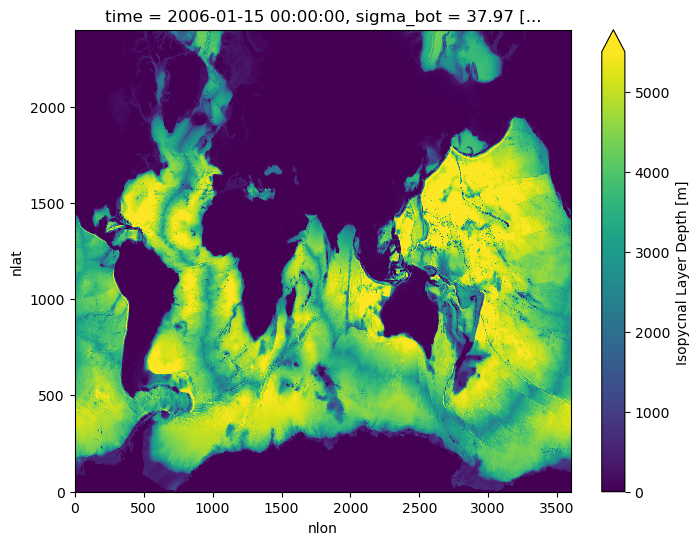

In [19]:
%%time
for n in range(len(ystart)):
    print("starting loop over {}-{} at {}".format(ystart[n], yend[n], time.ctime()))
    print('determining time subset of files to operate on')
    v_e = v_e_all.sel(time=slice(cftime.DatetimeNoLeap(ystart[n], 1, 1), cftime.DatetimeNoLeap(yend[n], 12, 31)))
    u_e = u_e_all.sel(time=slice(cftime.DatetimeNoLeap(ystart[n], 1, 1), cftime.DatetimeNoLeap(yend[n], 12, 31)))
    salt = salt_all.sel(time=slice(cftime.DatetimeNoLeap(ystart[n], 1, 1), cftime.DatetimeNoLeap(yend[n], 12, 31)))
    temp = temp_all.sel(time=slice(cftime.DatetimeNoLeap(ystart[n], 1, 1), cftime.DatetimeNoLeap(yend[n], 12, 31)))

    # Compute sigma-2 field from POP model output
    refz = 2000
    refdep = xr.full_like(dsV['z_t'],refz).rename('REFDEP')

    # Sigma2 on model TLAT, TLONG
    print('calculating sigma2_T: {}'.format(time.ctime()))
    sigma2_T = pop_tools.eos(salt=salt,temp=temp,depth=refdep) - 1000
    sigma2_T = sigma2_T.assign_attrs({'long_name':'Sigma referenced to {}m'.format(refz),'units':'kg/m^3'})
    print('calculated sigma2_T: {}'.format(time.ctime()))

    print("refdep {}".format(refdep))
    print("sigma2_T {}".format(sigma2_T)) # TODO: Should have time, z_t, nlat, nlon dims
    
    # Define target sigma-2 vertical grid. Use a predefined target grid, or create your own!
    sigma_mid,sigma_edge = popmoc.sigma2_grid_86L()
    print('sigma_mid {}'.format(sigma_mid))
    print('sigma_edge {}'.format(sigma_edge))

    # Compute Isopycnal Layer Thickness (Can skip if not needed)
    # Here, test histogram by counting cells in each density bin. Vertical sum should be same as KMT.
    iso_count = histogram(sigma2_T, bins=[sigma_edge.values],dim=['z_t'],density=False)
    iso_count = iso_count.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

    kmtdiff = iso_count.sum('sigma') - ds_grid['KMT']
    print("Max difference from true KMT for iso_count = {}".format(abs(kmtdiff).max().values))
    
    # Use histogram to compute layer thickness. Vertical sum should be same as HT.
    iso_thick = histogram(sigma2_T, bins=[sigma_edge.values], weights=dzt,dim=['z_t'],density=False)
    iso_thick = iso_thick.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
    iso_thick = iso_thick.rename('iso_thick').assign_attrs({'units':'m',
                                                            'long_name':'Isopycnal Layer Thickness'}).rename({'sigma':
                                                                                                              'sigma_mid'})
    print('iso_thick {} at {}'.format(time.ctime(), iso_thick))
    # TODO: check time transpose with more than one time slice
    iso_thick = iso_thick.transpose('time','sigma_mid','nlat','nlon')
    
    # takes somewhat long time to run this cell... it's also not really using dask.
    htdiff = iso_thick.sum('sigma_mid') - (ds_grid['HT']/100.).assign_attrs({'units':'m'})
    try:
        print("Max difference of iso_thick from true HT = {}m".format(abs(htdiff).max().values))
    except: # CancelledError
        print("Max difference of iso_thick  from true HT cannot be determined due to existence of NaN's")
        # TODO: there's some nan values that are causing this to fail. Tried abs(htdiff).max(skipna=True).values , to no avail.
        # This works: abs(htdiff[:,:,:1000]).max().values

    # Compute Isopycnal Layer Depth (Can skip if not needed)
    # Cumulative sum of layer thickness yields depth of layer edges:
    iso_depth = iso_thick.cumsum('sigma_mid').rename('iso_depth').rename({'sigma_mid':'sigma_bot'}).assign_attrs({'units':'m','long_name':'Isopycnal Layer Depth'})
    sigma_bot = sigma_edge.isel(sigma=slice(1,None)).rename({'sigma':'sigma_bot'}).assign_attrs({'long_name':'Sigma2 at bottom of layer'})
    iso_depth['sigma_bot'] = sigma_bot
    iso_depth = iso_depth.transpose('time', 'sigma_bot','nlat','nlon')
    print('iso_depth {} at {}'.format(time.ctime(), iso_depth))
    
    iso_depth.isel(time=0,sigma_bot=84).plot(size=6,vmax=5500)
    
    # Isopycnal depth of bottom-most layer should be same as HT.
    htdiff =  iso_depth.isel(sigma_bot=-1) - (ds_grid['HT']/100.).assign_attrs({'units':'m'})
    try:
        print("Max difference of iso_depth from true HT = {}m".format(abs(htdiff).max().values))
    except: # CancelledError
        print("Max difference of iso_depth from true HT cannot be determined due to existence of NaN's")

    # Compute Isopycnal Layer Horizontal Volume Flux
    # Grid Metrics
    print('computing grid metrics at {}'.format(time.ctime()))
    dxu = ds_grid['DXU']
    dyu = ds_grid['DYU']
    dxt = ds_grid['DXT']
    dyt = ds_grid['DYT']
    
    # Grid-oriented Volume FLuxes:
    print('generating grid-oriented volume fluxes at {}'.format(time.ctime()))
    u_e = (u_e*dyu*dzu/1.e4).assign_attrs({'units':'m^3/s'})
    v_e = (v_e*dxu*dzu/1.e4).assign_attrs({'units':'m^3/s'})
    
    # Convert u_e,v_e to C-grid fluxes
    print('converting to c-grid fluxes at {}'.format(time.ctime()))
    u = 0.5*(u_e+u_e.shift(nlat=1))
    v = 0.5*(v_e+v_e.roll(nlon=1,roll_coords=False))
    
    # Volume fluxes in density-space. 
    print('generating iso_flux at {}'.format(time.ctime()))
    iso_uflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=u,dim=['z_t'],density=False)
    iso_uflux = iso_uflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
    iso_vflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=v,dim=['z_t'],density=False)
    iso_vflux = iso_vflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
    
    print('performing dask operations at {}'.format(time.ctime()))
    iso_uflux = iso_uflux.persist()
    daskout = wait(iso_uflux)
    iso_vflux = iso_vflux.persist()
    daskout = wait(iso_vflux)
    
    # Vertical sum in density-space should reproduce vertical sum in depth-space
    ufluxdiff = iso_uflux.isel(time=0).sum('sigma') - u.isel(time=0).sum('z_t')
    try:
        print("Max difference from true Uflux = {}".format(abs(ufluxdiff).max().values))
    except:
        print("Max difference from true Uflux could not be determined")
    vfluxdiff = iso_vflux.isel(time=0).sum('sigma') - v.isel(time=0).sum('z_t')
    try:
        print("Max difference from true Vflux = {}".format(abs(vfluxdiff).max().values))
    except:
        print("Max difference from true Uflux could not be determined")
    
    # Compute Vertical Volume Flux from horizontal flux convergence
    print('computing vertical volume flux at {}'.format(time.ctime()))
    wflux = popmoc.wflux(iso_uflux,iso_vflux,'sigma',sigma_edge,grid='C')
    wflux = wflux.assign_coords({'TLAT':tlat,'TLONG':tlon})
    wflux = wflux.persist()
    daskout = wait(wflux)
    
    # plot
    print('plotting at {}'.format(time.ctime()))
    rmaskmoc.plot(levels=[0,1,2,3],col='transport_reg',size=5)
    plt.show()
    
    # Compute MOC
    print('computing MOC at {}'.format(time.ctime()))
    MOC = popmoc.compute_MOC(wflux,rmaskmoc,ds_moctemp.lat_aux_grid)
    MOC = MOC.transpose('time','transport_reg','sigma','lat_aux_grid')
    MOC = MOC.load()

    # add vflux at southern boundary of Atlantic domain
    tmp = iso_vflux*(rmaskmoc.shift(nlat=-1))
    tmp = tmp.isel(nlat=atl_j,transport_reg=1).sum('nlon')
    moc_s = -tmp.sortby('sigma',ascending=False).cumsum('sigma').sortby('sigma',ascending=True)/1.e6
    moc_s['sigma'] = sigma_edge.isel(sigma=slice(0,-1))
    MOC[{'transport_reg':1}] = MOC[{'transport_reg':1}] + moc_s
    
    try:
        MOC.isel(time=0).isel(transport_reg=0).plot(ylim=[40,28])
        plt.show()
    except:
        print("failed top lot MOC transport_reg=0")
    try:
        MOC.isel(time=0).isel(transport_reg=1).plot(ylim=[40,28])
        plt.show()
    except:
        print("failed top lot MOC transport_reg=1")
    
    # Save to netcdf
    MOCann = MOC.groupby('time.year').mean('time').rename({'year':'time'})
    dsout = MOCann.to_dataset()
    
    outdir = os.path.dirname(fin)
    fout = os.path.split(fin)[-1].split('.')[:-3]
    fout.append('MOCsig')
    fout.append('{:04d}-{:04d}'.format(dsout.time.values[0],dsout.time.values[-1]))
    # fout.append('{:04d}{:02d}-{:04d}{:02d}'.format(dsout.time.dt.year[0].values,dsout.time.dt.month[0].values,dsout.time.dt.year[-1].values,dsout.time.dt.month[-1].values))
    fout.append('nc')
    fout = '.'.join(fout)
    fout = os.path.join(outdir,fout)

    dsout.to_netcdf(fout,unlimited_dims='time')
    print("wrote {} at {}".format(fout, time.ctime()))

In [55]:
print(dask.__version__)
print(dask.distributed.__version__)

2022.7.0
2022.7.0


## Testing loop above with individual cells:

starting loop over 2006-2006 at Fri Mar  3 11:47:43 2023
determining time subset of files to operate on
calculating sigma2_T: Fri Mar  3 11:47:43 2023
calculated sigma2_T: Fri Mar  3 12:00:00 2023
refdep <xarray.DataArray 'REFDEP' (z_t: 62)>
array([2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.],
      dtype=float32)
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
Attributes:
    long_name:  depth from surface to midpoint of layer
    units:      centimeters
    positive:   down
    valid_min:  500.0
    valid_max:  587499.06
si

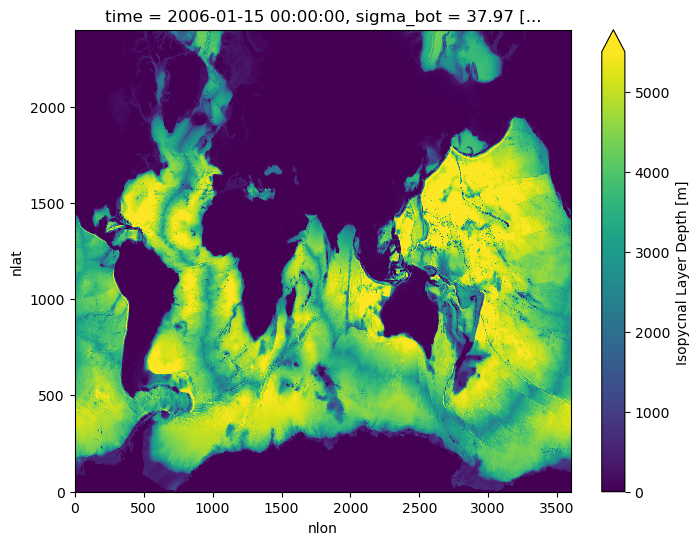

In [20]:
print("starting loop over {}-{} at {}".format(ystart[n], yend[n], time.ctime()))
print('determining time subset of files to operate on')
v_e = v_e_all.sel(time=slice(cftime.DatetimeNoLeap(ystart[n], 1, 1), cftime.DatetimeNoLeap(yend[n], 12, 31)))
u_e = u_e_all.sel(time=slice(cftime.DatetimeNoLeap(ystart[n], 1, 1), cftime.DatetimeNoLeap(yend[n], 12, 31)))
salt = salt_all.sel(time=slice(cftime.DatetimeNoLeap(ystart[n], 1, 1), cftime.DatetimeNoLeap(yend[n], 12, 31)))
temp = temp_all.sel(time=slice(cftime.DatetimeNoLeap(ystart[n], 1, 1), cftime.DatetimeNoLeap(yend[n], 12, 31)))

# Compute sigma-2 field from POP model output
refz = 2000
refdep = xr.full_like(dsV['z_t'],refz).rename('REFDEP')

# Sigma2 on model TLAT, TLONG
print('calculating sigma2_T: {}'.format(time.ctime()))
sigma2_T = pop_tools.eos(salt=salt,temp=temp,depth=refdep) - 1000
sigma2_T = sigma2_T.assign_attrs({'long_name':'Sigma referenced to {}m'.format(refz),'units':'kg/m^3'})
print('calculated sigma2_T: {}'.format(time.ctime()))

print("refdep {}".format(refdep))
print("sigma2_T {}".format(sigma2_T)) # TODO: Should have time, z_t, nlat, nlon dims

# Define target sigma-2 vertical grid. Use a predefined target grid, or create your own!
sigma_mid,sigma_edge = popmoc.sigma2_grid_86L()
print('sigma_mid {}'.format(sigma_mid))
print('sigma_edge {}'.format(sigma_edge))

# Compute Isopycnal Layer Thickness (Can skip if not needed)
# Here, test histogram by counting cells in each density bin. Vertical sum should be same as KMT.
iso_count = histogram(sigma2_T, bins=[sigma_edge.values],dim=['z_t'],density=False)
iso_count = iso_count.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

kmtdiff = iso_count.sum('sigma') - ds_grid['KMT']
print("Max difference from true KMT for iso_count = {}".format(abs(kmtdiff).max().values))

# Use histogram to compute layer thickness. Vertical sum should be same as HT.
iso_thick = histogram(sigma2_T, bins=[sigma_edge.values], weights=dzt,dim=['z_t'],density=False)
iso_thick = iso_thick.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
iso_thick = iso_thick.rename('iso_thick').assign_attrs({'units':'m',
                                                        'long_name':'Isopycnal Layer Thickness'}).rename({'sigma':
                                                                                                          'sigma_mid'})
print('iso_thick {} at {}'.format(iso_thick, time.ctime()))
# TODO: check time transpose with more than one time slice
iso_thick = iso_thick.transpose('time','sigma_mid','nlat','nlon')

# takes somewhat long time to run this cell... it's also not really using dask.
htdiff = iso_thick.sum('sigma_mid') - (ds_grid['HT']/100.).assign_attrs({'units':'m'})
try:
    print("Max difference of iso_thick from true HT = {}m".format(abs(htdiff).max().values))
except: # CancelledError
    print("Max difference of iso_thick  from true HT cannot be determined due to existence of NaN's")
    # TODO: there's some nan values that are causing this to fail. Tried abs(htdiff).max(skipna=True).values , to no avail.
    # This works: abs(htdiff[:,:,:1000]).max().values

# Compute Isopycnal Layer Depth (Can skip if not needed)
# Cumulative sum of layer thickness yields depth of layer edges:
iso_depth = iso_thick.cumsum('sigma_mid').rename('iso_depth').rename({'sigma_mid':'sigma_bot'}).assign_attrs({'units':'m','long_name':'Isopycnal Layer Depth'})
sigma_bot = sigma_edge.isel(sigma=slice(1,None)).rename({'sigma':'sigma_bot'}).assign_attrs({'long_name':'Sigma2 at bottom of layer'})
iso_depth['sigma_bot'] = sigma_bot
iso_depth = iso_depth.transpose('time', 'sigma_bot','nlat','nlon')
print('iso_depth {} at {}'.format(time.ctime(), iso_depth))

iso_depth.isel(time=0,sigma_bot=84).plot(size=6,vmax=5500)

# Isopycnal depth of bottom-most layer should be same as HT.
htdiff =  iso_depth.isel(sigma_bot=-1) - (ds_grid['HT']/100.).assign_attrs({'units':'m'})
try:
    print("Max difference of iso_depth from true HT = {}m".format(abs(htdiff).max().values))
except: # CancelledError
    print("Max difference of iso_depth from true HT cannot be determined due to existence of NaN's")

# Compute Isopycnal Layer Horizontal Volume Flux
# Grid Metrics
print('computing grid metrics at {}'.format(time.ctime()))
dxu = ds_grid['DXU']
dyu = ds_grid['DYU']
dxt = ds_grid['DXT']
dyt = ds_grid['DYT']

# Grid-oriented Volume FLuxes:
print('generating grid-oriented volume fluxes at {}'.format(time.ctime()))
u_e = (u_e*dyu*dzu/1.e4).assign_attrs({'units':'m^3/s'})
v_e = (v_e*dxu*dzu/1.e4).assign_attrs({'units':'m^3/s'})

# Convert u_e,v_e to C-grid fluxes
print('converting to c-grid fluxes at {}'.format(time.ctime()))
u = 0.5*(u_e+u_e.shift(nlat=1))
v = 0.5*(v_e+v_e.roll(nlon=1,roll_coords=False))

# Volume fluxes in density-space. 
print('generating iso_flux at {}'.format(time.ctime()))
iso_uflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=u,dim=['z_t'],density=False)
iso_uflux = iso_uflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
iso_vflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=v,dim=['z_t'],density=False)
iso_vflux = iso_vflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

In [56]:
iso_uflux

,Array,Chunk
Bytes,66.43 GiB,157.47 MiB
Shape,"(12, 2400, 3600, 86)","(1, 2400, 100, 86)"
Count,432 Tasks,432 Chunks
Type,float64,numpy.ndarray


In [114]:
iso_uflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=u,dim=['z_t'],density=False)
iso_uflux = iso_uflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})
iso_vflux = histogram(sigma2_T, bins=[sigma_edge.values],weights=v,dim=['z_t'],density=False)
iso_vflux = iso_vflux.rename({'density_bin':'sigma'}).assign_coords({'sigma':sigma_mid})

In [90]:
daskout = wait(iso_uflux)

In [115]:
iso_uflux = iso_uflux.persist()

In [116]:
iso_uflux

,Array,Chunk
Bytes,66.43 GiB,157.47 MiB
Shape,"(12, 2400, 3600, 86)","(1, 2400, 100, 86)"
Count,432 Tasks,432 Chunks
Type,float64,numpy.ndarray


In [93]:
client.futures

# The same tasks are the ones that fail when call wait (eg, 'sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 5, 0),
# even after client.futures is empty list


{"('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 5, 0)": <FutureState: pending>,
 "('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 2, 0)": <FutureState: pending>,
 "('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 30, 0)": <FutureState: pending>,
 "('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 19, 0)": <FutureState: pending>,
 "('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 30, 0)": <FutureState: pending>,
 "('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 3, 0)": <FutureState: pending>,
 "('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 33, 0)": <FutureState: pending>,
 "('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 35, 0)": <FutureState: pending>,
 "('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 22, 0)": <FutureState: pending>,
 "('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 30, 0)": <FutureState: pending>,
 "('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 31, 0)": <FutureState

In [105]:
daskout

DoneAndNotDoneFutures(done=set(), not_done=set())

In [106]:
client.futures

{}

In [107]:
daskout

DoneAndNotDoneFutures(done=set(), not_done=set())

In [113]:
daskout = wait(iso_uflux)
# failed even after client.futures was {}

CancelledError: [('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 33, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 27, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 28, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 11, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 32, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 10, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 34, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 3, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 14, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 22, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 30, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 6, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 1, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 2, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 12, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 35, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 1, 0, 25, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 0, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 9, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 8, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 21, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 6, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 23, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 19, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 13, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 8, 0, 18, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 4, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 15, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 10, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 24, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 7, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 16, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 2, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 11, 0, 29, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 5, 0, 26, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 7, 0, 31, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 4, 0, 17, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 20, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 0, 0, 5, 0), ('sum-aggregate-d2563e520941b0bd0f63998798870360', 3, 0, 5, 0)]

In [88]:
client.futures

{}

In [112]:
iso_uflux

,Array,Chunk
Bytes,66.43 GiB,157.47 MiB
Shape,"(12, 2400, 3600, 86)","(1, 2400, 100, 86)"
Count,432 Tasks,432 Chunks
Type,float64,numpy.ndarray


In [118]:
client.futures

{}

In [ ]:
# client.futures went from containing sum aggregate tasks to nothing without any activity on dask dashboard.
# dask-worker error log: Event loop was unresponsive in Worker for 4.27s. ...
# This is often caused by long-running GIL-holding functions or moving large chunks of data.
# This can cause timeouts and instability.

# Global Interpreter Lock: forces only one thread to hold control of python interpreter


In [119]:
import distributed
print(distributed.__version__)
# there was an issue in a previous version but not this one

2022.7.0


In [108]:
iso_uflux

,Array,Chunk
Bytes,66.43 GiB,157.47 MiB
Shape,"(12, 2400, 3600, 86)","(1, 2400, 100, 86)"
Count,432 Tasks,432 Chunks
Type,float64,numpy.ndarray


In [120]:
iso_vflux = iso_vflux.persist()


In [121]:
daskout = wait(iso_vflux)

CancelledError: [('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 4, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 19, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 30, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 21, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 17, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 6, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 1, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 23, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 34, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 32, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 27, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 10, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 0, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 11, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 8, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 20, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 1, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 25, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 22, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 15, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 33, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 11, 0, 7, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 31, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 5, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 2, 0, 12, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 7, 0, 28, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 9, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 26, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 18, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 3, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 10, 0, 14, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 3, 0, 29, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 5, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 35, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 4, 0, 16, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 2, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 9, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 8, 0, 13, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 24, 0), ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 6, 0, 35, 0)]

In [64]:
# Vertical sum in density-space should reproduce vertical sum in depth-space
ufluxdiff = iso_uflux.isel(time=0).sum('sigma') - u.isel(time=0).sum('z_t')
try:
    print("Max difference from true Uflux = {}".format(abs(ufluxdiff).max().values))
except:
    print("Max difference from true Uflux could not be determined")
vfluxdiff = iso_vflux.isel(time=0).sum('sigma') - v.isel(time=0).sum('z_t')
try:
    print("Max difference from true Vflux = {}".format(abs(vfluxdiff).max().values))
except:
    print("Max difference from true Uflux could not be determined")

# Compute Vertical Volume Flux from horizontal flux convergence
print('computing vertical volume flux at {}'.format(time.ctime()))
wflux = popmoc.wflux(iso_uflux,iso_vflux,'sigma',sigma_edge,grid='C')
wflux = wflux.assign_coords({'TLAT':tlat,'TLONG':tlon})

Max difference from true Uflux could not be determined
Max difference from true Uflux could not be determined
computing vertical volume flux at Fri Mar  3 12:31:41 2023


In [ ]:
# wflux = wflux.persist()
# daskout = wait(wflux)

plotting at Fri Mar  3 12:31:52 2023


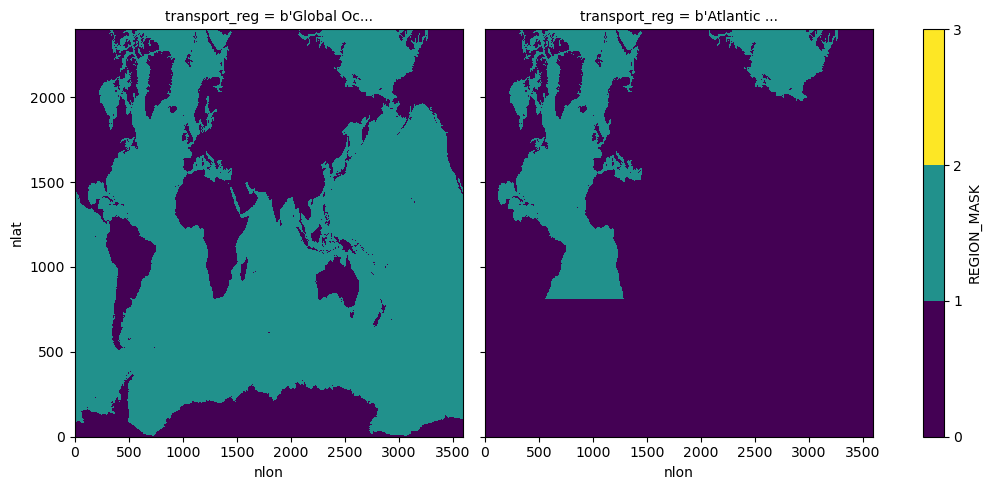

In [65]:
# plot
print('plotting at {}'.format(time.ctime()))
rmaskmoc.plot(levels=[0,1,2,3],col='transport_reg',size=5)
plt.show()

In [66]:
# Compute MOC
print('computing MOC at {}'.format(time.ctime()))
MOC = popmoc.compute_MOC(wflux,rmaskmoc,ds_moctemp.lat_aux_grid)
MOC = MOC.transpose('time','transport_reg','sigma','lat_aux_grid')
# MOC = MOC.load()

# add vflux at southern boundary of Atlantic domain
tmp = iso_vflux*(rmaskmoc.shift(nlat=-1))
tmp = tmp.isel(nlat=atl_j,transport_reg=1).sum('nlon')
moc_s = -tmp.sortby('sigma',ascending=False).cumsum('sigma').sortby('sigma',ascending=True)/1.e6
moc_s['sigma'] = sigma_edge.isel(sigma=slice(0,-1))
MOC[{'transport_reg':1}] = MOC[{'transport_reg':1}] + moc_s

try:
    MOC.isel(time=0).isel(transport_reg=0).plot(ylim=[40,28])
    plt.show()
except:
    print("failed top lot MOC transport_reg=0")
try:
    MOC.isel(time=0).isel(transport_reg=1).plot(ylim=[40,28])
    plt.show()
except:
    print("failed top lot MOC transport_reg=1")

computing MOC at Fri Mar  3 12:32:11 2023
failed top lot MOC transport_reg=0
failed top lot MOC transport_reg=1


In [69]:
MOC.isel(time=0).isel(transport_reg=1).plot(ylim=[40,28])

CancelledError: ('sum-aggregate-105c5cb8f06276377bb024de05deb528', 0, 0, 29, 0)

In [70]:
# Save to netcdf
MOCann = MOC.groupby('time.year').mean('time').rename({'year':'time'})
dsout = MOCann.to_dataset()

outdir = os.path.dirname(fin)
fout = os.path.split(fin)[-1].split('.')[:-3]
fout.append('MOCsig')
fout.append('{:04d}-{:04d}'.format(dsout.time.values[0],dsout.time.values[-1]))
# fout.append('{:04d}{:02d}-{:04d}{:02d}'.format(dsout.time.dt.year[0].values,dsout.time.dt.month[0].values,dsout.time.dt.year[-1].values,dsout.time.dt.month[-1].values))
fout.append('nc')
fout = '.'.join(fout)
fout = os.path.join(outdir,fout)

dsout.to_netcdf(fout,unlimited_dims='time')
print("wrote {} at {}".format(fout, time.ctime()))

CancelledError: ('sum-aggregate-d2563e520941b0bd0f63998798870360', 9, 0, 7, 0)

In [72]:
client.futures

{}

In [71]:
MOC

<xarray.DataArray 'MOC' (time: 12, transport_reg: 2, sigma: 86,
                         lat_aux_grid: 394)>
dask.array<setitem, shape=(12, 2, 86, 394), dtype=float32, chunksize=(1, 2, 86, 394), chunktype=numpy.ndarray>
Coordinates:
  * lat_aux_grid   (lat_aux_grid) float32 -78.95 -78.42 -77.88 ... 89.47 90.0
  * time           (time) object 2006-01-15 00:00:00 ... 2006-12-15 00:00:00
  * sigma          (sigma) float32 0.0 28.1 28.3 28.5 ... 37.88 37.93 37.97
  * transport_reg  (transport_reg) |S256 b'Global Ocean - Marginal Seas' b'At...
Attributes:
    long_name:  Meridional Overturning Circulation
    units:      Sv

In [52]:
MOCann.isel(time=0,transport_reg=1, sigma=2, lat_aux_grid=0)
# unable to compute this value...

<xarray.DataArray 'MOC' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    lat_aux_grid   float32 -78.95
    sigma          float32 28.3
    transport_reg  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador Sea ...
    time           int64 2006
Attributes:
    long_name:  Meridional Overturning Circulation
    units:      Sv